In [102]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Vegetation Change

This notebook uses changes in NDVI, EVI or Fractional Cover to identify vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. Significant reductions in vegetation are coincident with land change. In some cases these changes could be deforestation. Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

In [103]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [104]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

# Import Data Cube API
import datacube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()#config = '/home/localuser/.datacube.conf')
dc = api.dc


import odc.algo

from datacube_utilities.dc_display_map import display_map
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.createindices import NDVI, EVI
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic, create_mean_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.dc_water_classifier import wofs_classify
from pyproj import Proj, transform
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, Greens
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_png_from_xr, write_geotiff_from_xr
import dask

In [105]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

## Set Variables

In [106]:
#inputs
#options "LANDSAT_8" and "SENTINEL_2"
#platform is the sensor, options include 'LANSAT_8', 'LANSAT_7', 'LANSAT_5', 'LANSAT_4', 'SENTINEL_2'
platform_base = 'LANDSAT_8'
platform_analysis = 'LANDSAT_8'
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (30)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2015-3-1'
baseline_end_date = '2015-9-1'

#set the analysis start and end of period
analysis_start_date = '2016-3-1'
analysis_end_date = '2016-9-1'


# Options are: max, median, mean, geomedian
mosaic_type = "median" 

#central area - do dates 2013- 2014 and 2018-2019
#aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"

#select an indicies, options are 'EVI', 'NDVI' or 'FC', different indicies will perform better in different areas. 
indices = 'NDVI'

# values for thresholds
#### 
#typical for ndvi
minC = -0.7
maxC = -0.2
#typical for evi
#minC = -1.75
#maxC = -0.5
#typical for FC
#minC = -70
#maxC = -20


## Create AOI

In [107]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [108]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [109]:

inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [110]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [111]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [112]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

## Translate inputs and load data

In [113]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements, water_product

In [114]:
#create resolution
resolution = (-res, res)

In [115]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [116]:
baseline_product, baseline_measurement, baseline_water_product = create_product_measurement(platform_base)
analysis_product, analysis_measurement, analysis_water_product = create_product_measurement(platform_analysis)

In [117]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)

print(baseline_time_period)

(datetime.date(2015, 3, 1), datetime.date(2015, 9, 1))


# Load and Clean Data

In [118]:
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks
}

In [119]:
baseline_ds = dc.load(
    time = baseline_time_period,
    platform = platform_base,
    product = baseline_product,
    measurements = baseline_measurement,
    **query
)


In [120]:
analysis_ds = dc.load(
    time = analysis_time_period,
    platform = platform_analysis,
    product = analysis_product,
    measurements = analysis_measurement,
    **query
)

> #### Check if loads are valid

In [121]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [122]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [123]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

## Create Cloud Mask
Generating boolean masks that highlight valid pixels
Pixels must be cloud-free over land or water to be considered

In [124]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification == 4) | # clear
            (ds.scene_classification == 5) | 
            (ds.scene_classification == 7) | 
            (ds.scene_classification == 2) | 
            (ds.scene_classification == 6)  #water
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130) |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [125]:
baseline_clean_mask = look_up_clean(platform_base, baseline_ds)
analysis_clean_mask = look_up_clean(platform_analysis, analysis_ds)

In [126]:
xx_data_b = baseline_ds[allmeasurements]
xx_data_a = analysis_ds[allmeasurements]

In [127]:
xx_clean_b = odc.algo.keep_good_only(xx_data_b, where=baseline_clean_mask)

In [128]:
baseline_ds_masked = xx_clean_b

In [129]:
xx_clean_a = odc.algo.keep_good_only(xx_data_a, where=analysis_clean_mask)

In [130]:
analysis_ds_masked = xx_clean_a

In [131]:
mosaic_function = {"median": create_median_mosaic,
                   "max": create_max_ndvi_mosaic,
                   "mean" : create_mean_mosaic}

In [132]:
if mosaic_type in ["geomedian"]: 
    scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
    xx_clean_b_32 = to_f32(xx_clean_b, scale=scale, offset=offset)
    yy_b = xr_geomedian(xx_clean_b_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

    baseline_composite = from_float(yy_b, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)
    xx_clean_a_32 = to_f32(xx_clean_a, scale=scale, offset=offset)
    yy_a = xr_geomedian(xx_clean_a_32, 
                num_threads=1,  # disable internal threading, dask will run several concurrently
                eps=0.2*scale,  # 1/5 pixel value resolution
                nocheck=True)   # disable some checks inside geomedian library that use too much ram

    analysis_composite = from_float(yy_a, 
                dtype='int16', 
                nodata=-9999, 
                scale=1/scale, 
                offset=-offset/scale)
elif mosaic_type in ["median", "max_ndvi", "mean"]:   
    new_compositor = mosaic_function[mosaic_type]
    baseline_composite = dask.delayed(new_compositor)(baseline_ds_masked, clean_mask = baseline_clean_mask, no_data = np.nan)
    analysis_composite = dask.delayed(new_compositor)(analysis_ds_masked, clean_mask = analysis_clean_mask, no_data = np.nan)
    

In [133]:
#when S2 mask is ready - can remove the if statement. 
if platform_base in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_base = dc.load(product=baseline_water_product,
            measurements = ["water_classification"],
            time = baseline_time_period,
            platform = platform_base, 
               **query)
    #change clouds to no data value
    water_classes_base = water_scenes_base.where(water_scenes_base >= 0)
elif platform_base in ["SENTINEL_2"]:
    water_classes_base = dask.delayed(wofs_classify)(baseline_ds, clean_mask=baseline_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_base = dask.delayed(water_classes_base.rename({'wofs': 'water_classification'}))
            

In [134]:
#when S2 mask is ready - can remove the if statement. 
if platform_analysis in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes_analysis = dc.load(product=analysis_water_product,
            measurements = ["water_classification"],
            time = analysis_time_period,
            platform = platform_analysis,  
               **query)
    #change clouds to no data value
    water_classes_analysis = water_scenes_analysis.where(water_scenes_analysis >= 0)
elif platform_analysis in ["SENTINEL_2"]:
    water_classes_analysis = dask.delayed(wofs_classify)(analysis_ds, clean_mask=analysis_clean_mask.values , no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes_analysis = dask.delayed(water_classes_analysis.rename({'wofs': 'water_classification'}))
               

In [135]:
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude"})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude"})

## Spectral Parameter

In [136]:
def createparametercomposite(indices, ds):
    '''Calculate the chosen indicies. 
    '''
    if indices in ['ndvi', 'NDVI']:
        parameter_composite = NDVI(ds)
    elif indices in ['EVI', 'evi']:
        parameter_composite = EVI(ds)
    elif indices in ['FC']:
        #parameter_baseline_composite2 = frac_coverage_classify(baseline, clean_mask = baseline_clean_masked.values, no_data=np.nan)
        parameter_composite_all = frac_coverage_classify(ds, no_data = np.nan) 
        parameter_composite = parameter_composite_all.pv.where(np.logical_not(np.isnan(ds.red.values)))
    return parameter_composite

In [137]:
parameter_baseline_composite = dask.delayed(createparametercomposite)(indices, baseline_composite)
parameter_analysis_composite = dask.delayed(createparametercomposite)(indices, analysis_composite)

## Generate water mask

In [138]:
water_composite_base = dask.delayed(water_classes_base.water_classification.mean(dim='time'))

In [139]:
water_composite_analysis = dask.delayed(water_classes_analysis.water_classification.mean(dim='time'))

## Apply water mask

In [140]:
vegetation_baseline = parameter_baseline_composite.where(water_composite_base.values <= 0.4).where(parameter_baseline_composite !=-9999)

In [141]:
vegetation_analysis = parameter_analysis_composite.where(water_composite_analysis.values <= 0.4).where(parameter_analysis_composite !=-9999)

In [142]:
parameter_anomaly = vegetation_analysis - vegetation_baseline

In [143]:
%%time
parameter_anomaly_output = parameter_anomaly.compute()

CPU times: user 25.6 s, sys: 15.9 s, total: 41.6 s
Wall time: 7min 21s


# Spectral Parameter Anomaly

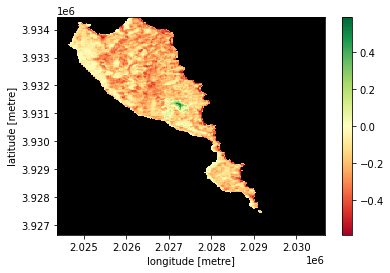

In [144]:
# Plot the parameter change from the baseline to the analysis period
# Significant loss in vegetation will be shown in RED
# Gains in vegetation will be shown in GREEN

#plt.figure(figsize = aspect_ratio_helper(parameter_anomaly)) 
parameter_anomaly_output.plot(cmap = RdYlGn)

In [145]:
# CHANGE HERE >>>>>>>>>>>>>
### This is one output we want
write_geotiff_from_xr('veg_change.tiff', parameter_anomaly_output, crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')

# Anomaly Threshold Product

In [146]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

In [147]:
no_data_mask = np.isnan(parameter_anomaly_output)
a = parameter_anomaly_output

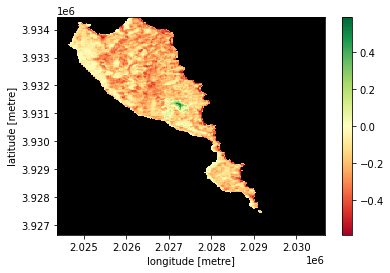

In [148]:
a.plot(cmap = "RdYlGn")

In [149]:
b = a.where((a < maxC) | (no_data_mask == True), 200) 

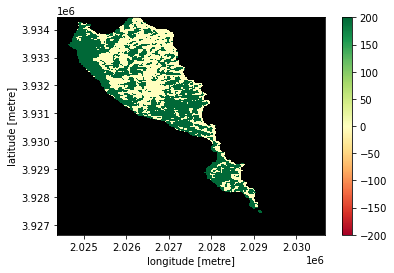

In [150]:
b.plot(cmap = "RdYlGn")

In [151]:
c = b.where((b > minC) | (no_data_mask == True), 300) 

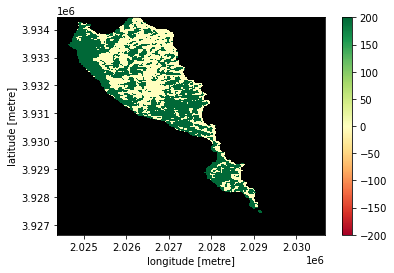

In [152]:
c.plot(cmap = "RdYlGn")

In [153]:
d = c.where(((c >= maxC) | (c <= minC)) | (no_data_mask == True), 100)

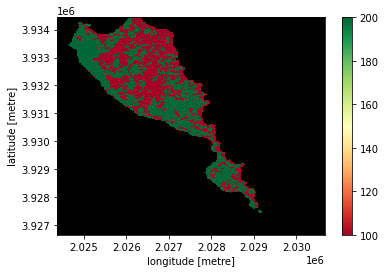

In [154]:
d.plot(cmap = "RdYlGn")

In [155]:
output = xr.DataArray.to_dataset(d, dim = None, name = 'param_thres')

In [156]:
#values of 300 are when the change is bigger than the minimum value, 200 when smaller, and 100 when within the range
write_geotiff_from_xr('param_thres.tiff', output, ["param_thres"], crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')